# Notebook to generate images with the three different models

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## DDPM

In [2]:
from diffusers import DDPMPipeline
import torch

pipe = DDPMPipeline.from_pretrained(
    "benetraco/brain_ddpm_256", 
    torch_dtype=torch.float32,
    safety_checker=None,
)
pipe.to("cuda")  # o "cpu"

# Generate samples
images = pipe(batch_size=4).images


Keyword arguments {'safety_checker': None} are not expected by DDPMPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

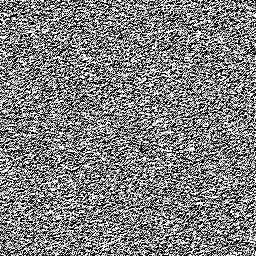

In [4]:
images[1]